In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

import random
import os
import copy
import time
import math
from math import sqrt

import matplotlib.pyplot as plt

In [2]:
def metric(y_test, y_hat, log=False):
    MSE  = mean_squared_error(y_test, y_hat)
    RMSE = sqrt(MSE)
    MAE  = mean_absolute_error(y_test, y_hat)
    MAPE = mean_absolute_percentage_error(y_test, y_hat)
    R2   = r2_score(y_test, y_hat)
    
    if log:
        print(f'\
MSE...............{MSE:.4f}\n\
RMSE..............{RMSE:.4f}\n\
MAE...............{MAE:.4f}\n\
MAPE..............{MAPE:.4f}\n\
R2................{R2:.4f}\
              ')
    
    return [MSE, RMSE, MAE, MAPE, R2]

In [3]:
def lagging_var(data, var, lags_list):
    lagged_df = data.copy()
    for name, lags in zip(var, lags_list):
        for lag in lags:
            if lag > 0: 
                lagged_df[name + '_L' + str(lag)] = lagged_df[name].shift(lag)
    lagged_df = lagged_df.fillna(0)
    return lagged_df

In [4]:
def unscale(data, dim, scaler):
    trainPredict_dataset_like = np.zeros(shape=(len(data), dim))
    trainPredict_dataset_like[:,0] = data[:,0]
    trainPredict = scaler.inverse_transform(trainPredict_dataset_like)[:,0]
    return trainPredict

In [5]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [42]:
# загрузка датасета
file_name = 'experiment_rsv'

df = pd.read_pickle(f"DATASET\\{file_name}.pkl")
    
df['ats_trg'] = df['ats'].rolling(5).mean()
df['ats_src'] = df['ats_trg'].shift(720)

df = df.drop(columns=['load_actual_sobr', 'generate_actual_sobr', 'rsv', 'price', 'ats']).dropna()
df = df[df.columns.tolist()[-2:] + df.columns.tolist()[:-2]] # изменить порядок столбцов
trg = df.pop('ats_trg')
df

,ats_src,month,day,day_of_week,year,index,workday,weekend,shortday,holiday,T2M,load_planned_sobr,generate_planned_sobr
2014-01-31 04:00:00,713.511987,1.0,31.0,4.0,2014.0,724.0,1.0,0.0,0.0,0.0,-33.270000,4216.000000,2663.000000
2014-01-31 05:00:00,709.313989,1.0,31.0,4.0,2014.0,725.0,1.0,0.0,0.0,0.0,-31.760000,4282.000000,2788.000000
2014-01-31 06:00:00,709.229980,1.0,31.0,4.0,2014.0,726.0,1.0,0.0,0.0,0.0,-30.410000,4309.000000,2788.000000
2014-01-31 07:00:00,709.481982,1.0,31.0,4.0,2014.0,727.0,1.0,0.0,0.0,0.0,-29.840000,4268.000000,2788.000000
2014-01-31 08:00:00,713.453992,1.0,31.0,4.0,2014.0,728.0,1.0,0.0,0.0,0.0,-29.850000,4280.000000,2746.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-31 19:00:00,1305.793994,7.0,31.0,6.0,2022.0,73003.0,0.0,1.0,0.0,0.0,17.730000,3164.051025,2015.900024
2022-07-31 20:00:00,1275.286011,7.0,31.0,6.0,2022.0,73004.0,0.0,1.0,0.0,0.0,17.280001,3087.885010,2025.900024
2022-07-31 21:00:00,1223.830005,7.0,31.0,6.0,2022.0,73005.0,0.0,1.0,0.0,0.0,16.889999,3038.926025,1995.900024
2022-07-31 22:00:00,1169.615991,7.0,31.0,6.0,2022.0,73006.0,0.0,1.0,0.0,0.0,16.690001,3041.237061,1995.900024


In [7]:
def data_prep(features, val_len=0.2, test_len=720, print_shapes=False):
    
    data = features.copy()
    y = pd.merge(trg, data.drop(columns=['ats_src']), left_index=True, right_index=True)
    X = data.to_numpy()
    y = y.to_numpy()

    X_train_val = X[:len(X) - test_len]
    y_train_val = y[:len(y) - test_len]

    X_test      = X[len(X) - test_len:]
    y_test      = y[len(y) - test_len:]
    X_train     = X_train_val[:int(len(X_train_val)*(1-val_len))]
    y_train     = y_train_val[:int(len(y_train_val)*(1-val_len))]
    X_val       = X_train_val[int(len(X_train_val)*(1-val_len)):]
    y_val       = y_train_val[int(len(y_train_val)*(1-val_len)):]

    scaler = MinMaxScaler(feature_range=(-1, 1)).fit(X_train)
    X_train, y_train = scaler.transform(X_train), scaler.transform(y_train)[:,0:1]
    X_val, y_val     = scaler.transform(X_val), scaler.transform(y_val)[:,0:1]
    X_test, y_test   = scaler.transform(X_test), scaler.transform(y_test)[:,0:1]
    
    feature_dim = X_train.shape[1]
    
    if print_shapes:
        print('Train data shape:')
        print(f'X_train -> {X_train.shape}')
        print(f'y_train -> {y_train.shape}')
        print('Val data shape:')
        print(f'X_val -> {X_val.shape}')
        print(f'y_val -> {y_val.shape}')
        print('Test data shape:')
        print(f'X_test -> {X_test.shape}')
        print(f'y_test -> {y_test.shape}')
        
    return X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim

In [11]:
def eval_metrics(model, X_val, y_val, X_test, y_test, scaler, feature_dim,
                 iter_name=None, plot_val=False, plot_test=False, print_scores=False,
                 return_forecast=False):
    
    yhat = model.predict(X_val)
    yhat = unscale(yhat.reshape(-1,1), feature_dim, scaler)
    yact = unscale(y_val, feature_dim, scaler)

    if plot_test:
        plt.figure(figsize=(18,4))
        plt.plot(yhat, label='forecast')
        plt.plot(yact, label='actual')
        plt.title(f'VALIDATION {iter_name}')
        plt.legend()
        plt.show()

    metrics_val = metric(yact, yhat, log=print_scores)

    # # # #

    yhat = model.predict(X_test)
    yhat = unscale(yhat.reshape(-1,1), feature_dim, scaler)
    yact = unscale(y_test, feature_dim, scaler)
    
    if plot_test:
        plt.figure(figsize=(18,4))
        plt.plot(yhat, label='forecast')
        plt.plot(yact, label='actual')
        plt.title(f'TEST {iter_name}')
        plt.legend()
        plt.show()

    metrics_test = metric(yact, yhat, log=print_scores)
    
    if not return_forecast:
        return metrics_val, metrics_test
    else:
        return metrics_val, metrics_test, yact, yhat

In [49]:
X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim = data_prep(features=df, 
                                                                                val_len=0.2, 
                                                                                test_len=720,  
                                                                                print_shapes=True)

Train data shape:
X_train -> (57217, 13)
y_train -> (57217, 1)
Val data shape:
X_val -> (14305, 13)
y_val -> (14305, 1)
Test data shape:
X_test -> (720, 13)
y_test -> (720, 1)


### Однократный запуск

Train data shape:
X_train -> (57217, 5)
y_train -> (57217, 1)
Val data shape:
X_val -> (14305, 5)
y_val -> (14305, 1)
Test data shape:
X_test -> (720, 5)
y_test -> (720, 1)


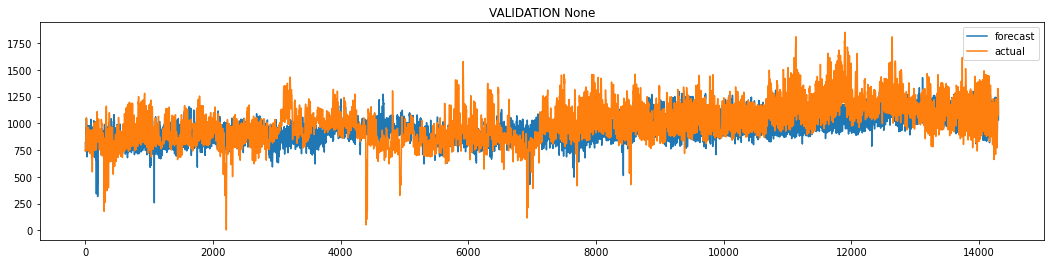

MSE...............28542.9178
RMSE..............168.9465
MAE...............126.5136
MAPE..............0.1572
R2................0.3111              


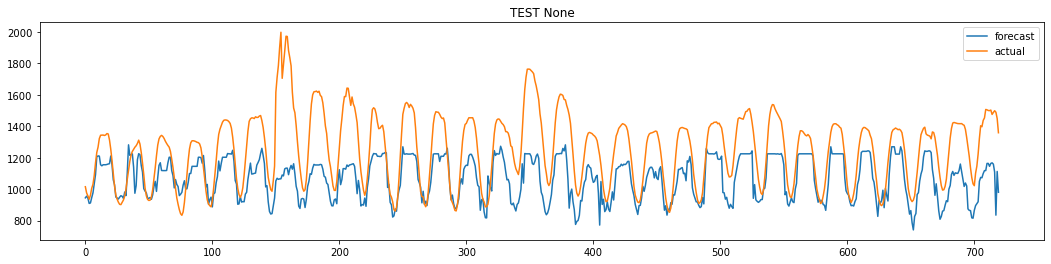

MSE...............58790.3736
RMSE..............242.4673
MAE...............196.6494
MAPE..............0.1459
R2................-0.1958              


In [58]:
main_features = lagging_var(data=df, 
                            var=['ats_src'], 
                            lags_list=[[1,6,12,24,24*2,24*3,24*7,24*14,24*30,24*60]])

X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim = data_prep(features=main_features[['ats_src', 'ats_src_L168', 'ats_src_L72', 'ats_src_L720', 'holiday']], 
                                                                                val_len=0.2, 
                                                                                test_len=720,  
                                                                                print_shapes=True)

seed_everything(SEED)
params = {'depth': 10, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
model = CatBoostRegressor(**params, verbose=False)
model.fit(X_train, y_train)

metrics_val, metrics_test, yact, yhat = eval_metrics(model, X_val, y_val, X_test, y_test, scaler, feature_dim,
                                                     iter_name=None, plot_val=True, plot_test=True, 
                                                     print_scores=True, return_forecast=True)

In [59]:
cat1month = pd.DataFrame({'yact' : yact, 'yhat' : yhat})
cat1month.to_pickle(f"DATASET\\cat1month.pkl")

### Итерировать по гиперпараметрам

In [51]:
main_features = lagging_var(data=df, 
                            var=['ats_src'], 
                            lags_list=[[1,6,12,24,24*2,24*3,24*7,24*14,24*30,24*60]])

X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim = data_prep(features=main_features[['ats_src', 'ats_src_L168', 'ats_src_L72', 'ats_src_L720', 'holiday']], 
                                                                                val_len=0.2, 
                                                                                test_len=720,  
                                                                                print_shapes=True)
seed_everything(SEED)

model = CatBoostRegressor(verbose=False)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

Train data shape:
X_train -> (57217, 5)
y_train -> (57217, 1)
Val data shape:
X_val -> (14305, 5)
y_val -> (14305, 1)
Test data shape:
X_test -> (720, 5)
y_test -> (720, 1)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.1563325799
bestIteration = 997

0:	loss: 0.1563326	best: 0.1563326 (0)	total: 3.05s	remaining: 1m 28s

bestTest = 0.1547761792
bestIteration = 998

1:	loss: 0.1547762	best: 0.1547762 (1)	total: 6.45s	remaining: 1m 30s

bestTest = 0.1565005809
bestIteration = 999

2:	loss: 0.1565006	best: 0.1547762 (1)	total: 9.63s	remaining: 1m 26s

bestTest = 0.1547953715
bestIteration = 996

3:	loss: 0.1547954	best: 0.1547762 (1)	total: 13.4s	remaining: 1m 27s

bestTest = 0.1565806864
bestIteration = 999

4:	loss: 0.1565807	best: 0.1547762 (1)	total: 16.7s	remaining: 1m 23s

bestTest = 0.1549343921
bestIteration = 986

5:	loss: 0.1549344	best: 0.1547762 (1)	total: 19.7s	remaining: 1m 18s

bestTest = 0.1566356683
bestIteration = 999

6:	loss: 0.1566357	best: 0.1547762 (1)	total: 22.8s	remaining: 1m 14s

bestTest = 0.1548855448
bestIteration = 999

7:	loss: 0.1548855	best: 0.1547762 (1)	total: 26s	remaining: 1m 11s

bestTest = 0.156721051
bestIteration = 998

8:	loss: 0.1567211	best: 0.15

In [52]:
grid_search_result

{'params': {'depth': 10, 'l2_leaf_reg': 5, 'learning_rate': 0.1},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
    

### Feature selection

In [43]:
np.set_printoptions(formatter={'float_kind' : "{:.3f}".format})

def train_model(data):
    print(f'\n{data.columns=}')
    
    X_train, y_train, X_val, y_val, X_test, y_test, scaler, feature_dim = data_prep(features=data, 
                                                                                    val_len=0.2, 
                                                                                    test_len=720,  
                                                                                    print_shapes=False)

    seed_everything(SEED)

    model = CatBoostRegressor(verbose=False)
    model.fit(X_train, y_train)

    metrics_val, metrics_test, yact, yhat = eval_metrics(model, X_val, y_val, X_test, y_test, scaler, feature_dim,
                                                         iter_name=None, plot_val=False, plot_test=False, 
                                                         print_scores=False, return_forecast=True)

    return model, metrics_val

def iterate(data):
    score = {}
    for i in main_features.columns:
        X = data.copy()
        X[i] = main_features[[i]]
        _, metrics = train_model(X)
        score.update({i : metrics[1]})
        results.loc[' + '.join(data.columns.tolist()), i] = metrics[1]
        print(f'....{i} -> RMSE={metrics[1]:.2f}')
    feature = min(score, key=score.get)
    print(f'Best feature - {feature}, metric improvment - {(score[feature]-prev_score):.3f} (acc = {score[feature]:.3f})')
    return feature, score[feature]

In [46]:
import warnings
warnings.filterwarnings('ignore')

main_features = lagging_var(data=df, 
                            var=['ats_src'], 
                            lags_list=[[1,6,12,24,24*2,24*3,24*7,24*14,24*30,24*60]])
data = pd.DataFrame(main_features.pop('ats_src'))
_, init_score = train_model(data)
init_score = init_score[1]
prev_score = init_score
print(f'Initial score = {prev_score:.3f}')

results = pd.DataFrame()
results.loc[' + '.join(data.columns.tolist()), ' + '.join(data.columns.tolist())] = prev_score
epoch = len(main_features.columns)
hold = 0
for f in range(1,epoch+1):
    start = time.time()
    best_feature, best_score = iterate(data)
    if best_score < prev_score:
        hold = 0
        data[best_feature] = main_features.pop(best_feature)
        prev_score = best_score
        best_x = data.copy()
        print(f'add - {best_feature}\n')
    elif hold < 0:
        hold += 1
        data[best_feature] = main_features.pop(best_feature)
        print(f'negative add - {best_feature}\n')
    else:
        break
print('Picked features ->', [c for c in best_x.columns], '\n')
# # # # # # # # # # # # # # # # # # # # # #

_, metrics = train_model(best_x)

print(metrics)


data.columns=Index(['ats_src'], dtype='object')
Initial score = 198.130

data.columns=Index(['ats_src', 'month'], dtype='object')
....month -> RMSE=200.85

data.columns=Index(['ats_src', 'day'], dtype='object')
....day -> RMSE=202.00

data.columns=Index(['ats_src', 'day_of_week'], dtype='object')
....day_of_week -> RMSE=197.65

data.columns=Index(['ats_src', 'year'], dtype='object')
....year -> RMSE=230.11

data.columns=Index(['ats_src', 'index'], dtype='object')
....index -> RMSE=224.84

data.columns=Index(['ats_src', 'workday'], dtype='object')
....workday -> RMSE=198.54

data.columns=Index(['ats_src', 'weekend'], dtype='object')
....weekend -> RMSE=198.49

data.columns=Index(['ats_src', 'shortday'], dtype='object')
....shortday -> RMSE=197.94

data.columns=Index(['ats_src', 'holiday'], dtype='object')
....holiday -> RMSE=198.08

data.columns=Index(['ats_src', 'T2M'], dtype='object')
....T2M -> RMSE=201.14

data.columns=Index(['ats_src', 'load_planned_sobr'], dtype='object')
....loa

....holiday -> RMSE=165.33

data.columns=Index(['ats_src', 'ats_src_L168', 'ats_src_L72', 'ats_src_L720', 'T2M'], dtype='object')
....T2M -> RMSE=178.93

data.columns=Index(['ats_src', 'ats_src_L168', 'ats_src_L72', 'ats_src_L720',
       'load_planned_sobr'],
      dtype='object')
....load_planned_sobr -> RMSE=174.80

data.columns=Index(['ats_src', 'ats_src_L168', 'ats_src_L72', 'ats_src_L720',
       'generate_planned_sobr'],
      dtype='object')
....generate_planned_sobr -> RMSE=173.05

data.columns=Index(['ats_src', 'ats_src_L168', 'ats_src_L72', 'ats_src_L720', 'ats_src_L1'], dtype='object')
....ats_src_L1 -> RMSE=167.30

data.columns=Index(['ats_src', 'ats_src_L168', 'ats_src_L72', 'ats_src_L720', 'ats_src_L6'], dtype='object')
....ats_src_L6 -> RMSE=171.16

data.columns=Index(['ats_src', 'ats_src_L168', 'ats_src_L72', 'ats_src_L720',
       'ats_src_L12'],
      dtype='object')
....ats_src_L12 -> RMSE=176.74

data.columns=Index(['ats_src', 'ats_src_L168', 'ats_src_L72', 'ats_sr

<AxesSubplot:>

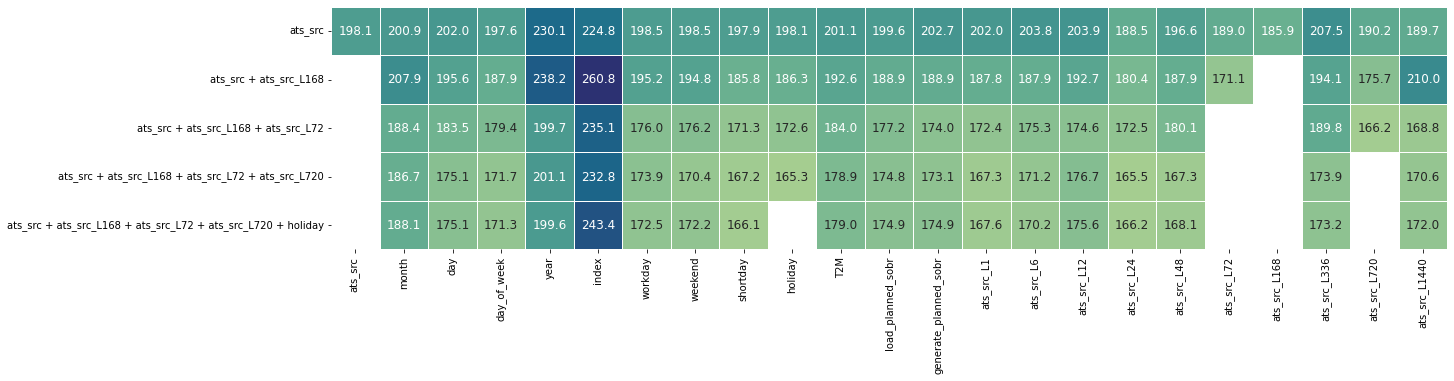

In [48]:
import seaborn as sns

plt.figure(figsize=(20, 20))
cmap = sns.color_palette("crest", as_cmap=True)
sns.heatmap(results, cmap=cmap, square=True, linewidths=.5, cbar=False, annot=True, fmt=".1f", annot_kws={"size":12})